说明：  
本文件使用的是 Data clean 1 的数据整理结果（除了 target 列外，全部填充完毕，没有缺失值）。训练 LR 模型。

<font face="微软雅黑" size=5> Contents： </font>  
1. XGBOOST特征重要性  
2. Logistic Regression  
&ensp;&ensp;&ensp;&ensp;2.1 特征标准化  
&ensp;&ensp;&ensp;&ensp;2.2 计算经验相关系数矩阵  
&ensp;&ensp;&ensp;&ensp;2.3 基于相关系数矩阵和XGB特征重要性的特征选择  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.3.1 先del_colinearity1 后 XGB特征重要性  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.3.2 del_colinearity2 内部融合XGB特征重要性  
&ensp;&ensp;&ensp;&ensp;2.4 两种特征选择方式在LR模型上初步尝试  
&ensp;&ensp;&ensp;&ensp;2.5 训练LR模型  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.1 准备数据集  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.2 GridSearchCV交叉验证粗取最佳超参数  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.3 对验证集进行预测并求得AUC---法1  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.4 对验证集进行预测并求得AUC---法2  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.5 查看并分析详细信息  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.6 hyperopt求取最佳超参数  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.7 交叉验证  
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;2.5.8 训练最终LR模型并预测未知样本集  
3. 提交结果  


In [1]:
import numpy as np
import pandas as pd
import time
from scipy import special
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,rand
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import time
from sklearn.externals import joblib
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# 读取数据集 data1，记为 data

data = pd.read_csv(r'F:\RiskPre2\Data clean 1\data1.csv').set_index("userID")

In [3]:
data.head()

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0.644378,0.049019,25.766646,14.131988,11.047256,5.839872,2.897174,44.916014,5914855887,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,20.376736,20.376736,0.000000,0.000000,3.000000,61.523250,5914855887,0.0
3,0,1,0,0,0,0,0,1,0,0,...,0.139983,0.087685,19.800723,13.605240,8.804037,4.214494,1.000000,18.361833,5914855887,0.0
4,0,1,0,0,0,0,0,1,0,0,...,0.000000,0.000000,18.767298,18.767298,0.000000,0.000000,3.000000,59.110850,5914855887,1.0
5,0,1,0,0,0,1,0,0,0,0,...,1.059802,0.053767,28.728905,16.445445,8.294372,3.533376,1.000000,20.664418,5914855887,0.0


In [4]:
# 从数据集 data中提取出训练集和未知样本集
# 训练集 data_tr，(55381, 425)。未知样本集 data_te，(13899, 425)

userIDtrain = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtrain.csv').values.flatten()
userIDtest = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtest.csv').values.flatten()
data_tr = data.loc[userIDtrain,:]
print("shape of data_tr is:",data_tr.shape )
data_te = data.loc[userIDtest,:]
print("shape of data_te is:",data_te.shape )

shape of data_tr is: (55381, 425)
shape of data_te is: (13899, 425)


In [5]:
userIDtrain

array([    1,     2,     3, ..., 55594, 55595, 55596], dtype=int64)

In [6]:
data_tr.head()

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0.644378,0.049019,25.766646,14.131988,11.047256,5.839872,2.897174,44.916014,5914855887,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,20.376736,20.376736,0.000000,0.000000,3.000000,61.523250,5914855887,0.0
3,0,1,0,0,0,0,0,1,0,0,...,0.139983,0.087685,19.800723,13.605240,8.804037,4.214494,1.000000,18.361833,5914855887,0.0
4,0,1,0,0,0,0,0,1,0,0,...,0.000000,0.000000,18.767298,18.767298,0.000000,0.000000,3.000000,59.110850,5914855887,1.0
5,0,1,0,0,0,1,0,0,0,0,...,1.059802,0.053767,28.728905,16.445445,8.294372,3.533376,1.000000,20.664418,5914855887,0.0


In [7]:
# 对训练集 data_tr 进行目标变量分离，分成 字段部分 X_tr和 目标变量部分 y_tr。
# 对未知样本集 data_te 进行目标变量分离，分成 字段部分 X_te和 目标变量部分 y_te。


X_tr = data_tr.drop(["target"],axis=1)
y_tr = data_tr.loc[:,"target"]
X_te = data_te.drop(["target"],axis=1)
y_te = data_te.loc[:,"target"]
print("shape of X_tr is:",X_tr.shape)
print("shape of y_tr is:",y_tr.shape)
print("shape of X_te is:",X_te.shape)
print("shape of y_te is:",y_te.shape)

shape of X_tr is: (55381, 424)
shape of y_tr is: (55381,)
shape of X_te is: (13899, 424)
shape of y_te is: (13899,)


In [8]:
X_tr.head(3)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_max,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,1.025837,0.644378,0.049019,25.766646,14.131988,11.047256,5.839872,2.897174,44.916014,5914855887
2,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,20.376736,20.376736,0.000000,0.000000,3.000000,61.523250,5914855887
3,0,1,0,0,0,0,0,1,0,0,...,1.326071,0.139983,0.087685,19.800723,13.605240,8.804037,4.214494,1.000000,18.361833,5914855887


In [9]:
y_tr.head(2)

userID
1    0.0
2    0.0
Name: target, dtype: float64

# 1. XGBOOST 特征重要性

1. 将训练集二八分划分成训练集和验证集（shuffle+stratify），训练集和验证集同时给到XGB，训练出XGB模型。通过feature_importance得到所有特征的重要性，并用表格法和图示法展示。
2. 用此模型小试一下，对验证集进行概率预测（关注排序而非真实的预测概率绝对值）。自定义 ks_statistic函数计算K-S统计量值为0.45， ks_curve函数画K-S图线。

In [10]:
# 使用 train_test_split 将 X_tr, y_tr 划分成训练集 X_tr_train,y_tr_train 和 验证集 X_tr_test, y_tr_test。
# 可见，训练集 38766 个用户，验证集 16615 个用户。
# train_test_split 默认 shuffle数据，所以不必担心。还可以设置 stratify 分层抽样。


X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_tr, y_tr, test_size = 0.2, shuffle=True, stratify=y_tr, random_state = 0)
print("shape of X_tr_train is:",X_tr_train.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test is:",X_tr_test.shape)
print("shape of y_tr_test is:",y_tr_test.shape)
scale_pos_weight_value=len(y_tr_train[y_tr_train==0])/len(y_tr_train[y_tr_train==1]) # XGB默认label==0是反类，label==1是正类。
print("negative number/positive number in y_tr_train is:",scale_pos_weight_value)
scale_pos_weight_value1=len(y_tr_test[y_tr_test==0])/len(y_tr_test[y_tr_test==1]) # XGB默认label==0是反类，label==1是正类。
print("negative number/positive number in y_tr_test is:",scale_pos_weight_value1)
# 可见，二八分得的训练集和验证集里的 正负样本比例基本相同，即实现了 stratify.

shape of X_tr_train is: (44304, 424)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 424)
shape of y_tr_test is: (11077,)
negative number/positive number in y_tr_train is: 6.7441006816990035
negative number/positive number in y_tr_test is: 6.746153846153846


In [11]:
X_tr_train.head()

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_max,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
950,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,20.376736,20.376736,10.188368,0.000000,2.0,42.631748,5915633487
52463,0,1,0,0,0,1,0,0,0,0,...,0.292912,0.114795,0.027480,23.711041,13.974282,9.369504,6.058268,5.0,60.501599,5931617487
26796,0,1,0,0,0,1,0,0,0,0,...,0.363387,0.072343,0.026336,24.047356,14.173112,9.999985,4.925065,3.0,39.814708,5928247887
32880,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,21.069883,21.069883,0.000000,0.000000,4.0,41.442164,5929198287
32092,0,0,1,0,0,0,1,0,0,0,...,0.000000,0.000000,0.000000,20.153592,20.153592,0.000000,0.000000,3.0,43.813742,5929111887


In [12]:
# 使用 X_tr_train,y_tr_train作为训练集 ，X_tr_test, y_tr_test作为验证集。训练一个 XGB模型。


modelXGB1 = XGBClassifier(
    max_depth=6,                        # 树的最大深度
    # learning_rate=0.1,（默认）         # 提升树的学习率                     
    n_estimators=1000,                  # 树的个数--1000棵树建立xgboost
    # silent = True,（默认）             # 此为默认设置，打印running boosting时的message。
    objective='binary:logistic',        # 指定损失函数
    # nthread = -1,（默认）              # 此为默认设置，并行线程数。
    # gamma=0,（默认）                   # 设置节点划分要达到的loss减小量
    # min_child_weight = 1,（默认）      # 叶子节点最小实例数据权重和
    # max_delta_step = 0,（默认）        # 此为默认设置，每棵树权重改变的最大步长。
    # subsample=1,（默认）               # 训练每棵树时实例数据随机采样的比例
    # colsample_btree=1,（默认）         # 训练每棵树时特征采样的比例
    # colsample_bylevel = 1,（默认）     # 此为默认设置，树的每一级的每一次分裂时，对特征的采样比例。
    # reg_alpha = 0,（默认）             # 此为默认设置，L1正则项系数。
    # reg_lambda = 1,（默认）            # 此为默认设置，L2正则项系数。
    scale_pos_weight = scale_pos_weight_value,   # 设置正类别样本的权重。解决正反样本个数不平衡的问题。
    # base_score = 0.5,（默认）          # 此为默认设置，
    seed = 1,                           # 随机数，因为涉及到随机采样等随机过程。
    missing = np.nan                    # XGB是能处理带缺失值的数据的模型，所以需要指出数据集中用什么代表缺失值。不过我的数据无缺失。      
    )

timestart = time.time()
modelXGB1.fit(X_tr_train,y_tr_train,eval_set = [(X_tr_train,y_tr_train),(X_tr_test, y_tr_test)],eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
print("Time: {:.2f} seconds".format(time.time() - timestart))

[0]	validation_0-logloss:0.669162	validation_0-auc:0.781234	validation_1-logloss:0.670913	validation_1-auc:0.743866
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.649867	validation_0-auc:0.789589	validation_1-logloss:0.652907	validation_1-auc:0.758868
[2]	validation_0-logloss:0.633333	validation_0-auc:0.794852	validation_1-logloss:0.638207	validation_1-auc:0.758414
[3]	validation_0-logloss:0.619523	validation_0-auc:0.798146	validation_1-logloss:0.625986	validation_1-auc:0.759382
[4]	validation_0-logloss:0.60772	validation_0-auc:0.80188	validation_1-logloss:0.615571	validation_1-auc:0.762851
[5]	validation_0-logloss:0.597535	validation_0-auc:0.80507	validation_1-logloss:0.60698	validation_1-auc:0.764637
[6]	validation_0-logloss:0.587915	validation_0-auc:0.811228	validation_1-logloss:0.599076	validation_1-auc:0.766086
[7]	validation_0-logloss:0.580161	v

[70]	validation_0-logloss:0.42749	validation_0-auc:0.91319	validation_1-logloss:0.495111	validation_1-auc:0.787057
[71]	validation_0-logloss:0.426462	validation_0-auc:0.913775	validation_1-logloss:0.494496	validation_1-auc:0.787303
[72]	validation_0-logloss:0.425339	validation_0-auc:0.914567	validation_1-logloss:0.493858	validation_1-auc:0.787172
Stopping. Best iteration:
[62]	validation_0-logloss:0.43844	validation_0-auc:0.905732	validation_1-logloss:0.500588	validation_1-auc:0.787411

Time: 171.69 seconds


&ensp;&ensp;以上结果如何解读？XGB是boost模型，第0轮训练出第0棵树，对训练集进行预测，与训练集的真实类别对比，计算的auc和logloss，再对验证集进行预测，与验证集的真实类别对比，计算出auc和logloss。还可以得到残差，第1轮对上轮的残差学习，得到第1棵树，如果与第0棵树相加，就是第1轮的集成学习器，此学习器同样对训练集进行预测，对验证集进行预测，得到两个集合的logloss与auc。logloss是稳步下降的，auc稳步提升。在第57轮达到峰值，之后10轮，auc值起伏不定，所以停止训练。所以最好的是第57轮的集成学习器，它包含了58棵树（因为有第0轮的第0棵树）。

In [15]:
# 以表格的形式查看特征重要性

featurenames = X_tr_train.columns
FeatureImportance = pd.DataFrame(data = modelXGB1.feature_importances_, index = featurenames, columns = ['feature importance'])
FeatureImportance = FeatureImportance.sort_values(by = ['feature importance'], ascending=False)

In [16]:
FeatureImportance

,feature importance
loan_time,0.023772
gender_OHE_0,0.014527
bill_AL_cardM__last_repay_amount_max,0.009509
browse_BLbn_10_count,0.008980
bill_AL_cardM__current_bill_balance_max,0.008980
bill_AL_cardM__last_repay_amount_median,0.007660
bill_AL_cardM__current_bill_minrepay_max,0.007396
bill_AL_last_repay_amount_max,0.007396
bill_AL_cardM__last_repay_amount_sum,0.007396
bill_AL_current_bill_amount_max,0.006867


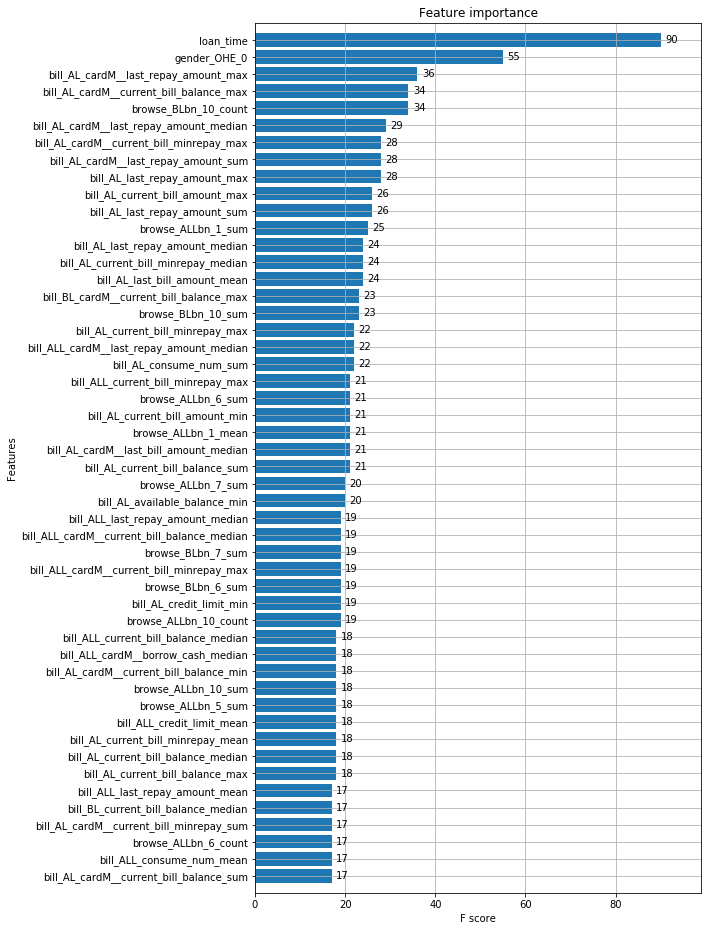

In [17]:
# 以作图形式显示 特征重要性。


fig1 = plt.figure(figsize = (8,16))
ax1 = fig1.add_subplot(111)
plot_importance(modelXGB1, ax1, height=0.8, xlim=None, ylim=None, 
                        title='Feature importance', xlabel='F score', ylabel='Features', 
                        importance_type='weight', grid=True,
                        max_num_features=50)
plt.show()
# 横轴label是 F score，这是默认的，其实就是特征重要性，每个特征出现在模型中的所有树中作为划分依赖的次数。

&ensp;&ensp;赛题选择的这个K-S统计量，只与被预测样本的排序有关，而与真正的逾期概率值本身的绝对大小无关。get到这点很重要。所以在训练模型的时候，我们关注的就仅仅是预测的排序，而非预测为违约的实际概率值。这种情况，用AUC作为评价函数就比较好，此指标只与排序有关，与预测的概率值的绝对大小无关。而且，这种情况下，若总体样本不平衡，则可以使用 scale_pos_weight或class_weight参数调整类别不平衡。（调整这样的参数会影响到 预测的概率值的绝对大小，但对提高预测排序的准确性有帮助）。

In [18]:
# 得到一个模型后，用模型对验证集进行概率预测，ks_statistic函数通过对比概率预测结果和验证集的真实类别结果，计算得到 K-S统计量值并返回。
# ks_statistic 函数的参数：y_predicted_proba是对验证集里的每个样本属于正类1的概率预测， y_true是验证集里每个样本的真实类别
# （1正类，0反类）
# 此函数的返回值是 模型对此样本集的预测所计算出的 K-S统计量。K-S统计量的取值范围是0-1，模型的分类效果越好，此值越大。

# 得到一个模型后，用模型对验证集进行概率预测，ks_curve函数可以通过此预测结果画出 K-S曲线。
# ks_curve函数的参数：y_predicted_proba是对验证集里的每个样本属于正类1的概率预测， y_true是验证集里每个样本的真实类别
# （1正类，0反类）
# 此函数返回 K-S 曲线。


def ks_statistic(y_true,y_predicted_proba):
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,pos_label=1)
    return abs(tpr-fpr).max()


def ks_curve(y_true,y_predicted_proba):
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,pos_label=1)
    
    font1 = {'family': 'Calibri','weight': 'normal','size': 18} # 轴标签字体
    font2 = {'family': 'Calibri','weight': 'normal','size': 23} # 图标题字体
    
    fig = plt.figure(figsize = (6,8))
    ax = fig.add_subplot(111)
    ax.plot(thresholds,1.0-tpr,label="overdue",color="navy")
    ax_t = ax.twinx()
    ax_t.plot(thresholds,1.0-fpr,label="normal",color="g")
    ax.plot(thresholds,tpr-fpr,label="K-S",color="darkorange")
    ax.legend(loc=2)
    ax_t.legend(loc=9)
    ax_t.set_xlim(0.0, 1.0)
    ax_t.set_ylim(0.0, 1.0)
    ax.set_title('K-S curve',fontdict=font2 ) 
    ax.set_xlabel('threshold',fontdict=font1,labelpad= 2)  
    ax.set_ylabel('True Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_ylabel('False Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
       
    plt.show()

In [19]:
# 用 modelXGB1 对验证集进行预测，用ks_statistic函数计算K-S统计量，值为0.45.


y_predict_proba1 = modelXGB1.predict_proba(X_tr_test, ntree_limit=58)
ks_value1 = ks_statistic(np.array(y_tr_test),y_predict_proba1[:,1])
print("ks_value1 is: ",ks_value1)

# 注意，predict_proba会得到每个样本属于每个类别的概率。y_predict_proba是二维array，一行是一个样本，第一列是属于反类0的概率，
# 第二列是属于正类1的概率，与 model.classes_ 对应。y_predict_proba[:,1] 选出了 对每个样本属于正类1的概率的预测结果。
# 另外，ntree_limit=58 是因为在训练model1的时候，得到最好的是第57轮，所以最佳的是第58棵集成树。（从第0轮开始，所以57+1）

ks_value1 is:  0.4478387063335752


In [20]:
y_predict_proba1

array([[0.83567417, 0.16432583],
       [0.9550059 , 0.04499412],
       [0.62542474, 0.37457523],
       ...,
       [0.86357033, 0.1364297 ],
       [0.688579  , 0.31142098],
       [0.8461034 , 0.15389656]], dtype=float32)

In [21]:
modelXGB1.classes_

array([0., 1.])

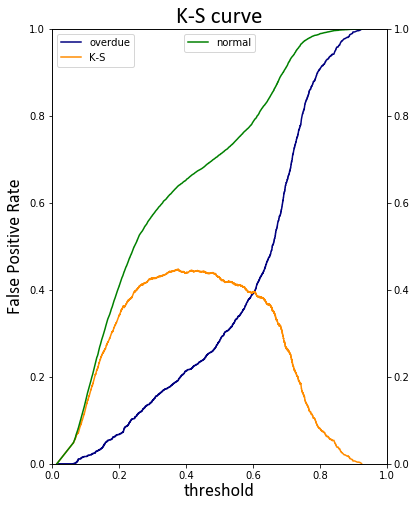

In [22]:
ks_curve(y_tr_test,y_predict_proba1[:,1])

# 2. Logistic Regression

1. 对训练集中的所有特征进行标准化（包括onehot encoder得到的特征 和 连续型数值特征），记录每个特征的均值方差，将其应用到未知样本集，对它们进行标准化。
2. 对训练集的所有特征计算相关系数矩阵。
3. 找出相关系数>0.7的变量，只保留其中之一，结合XGB的特征重要性，完成特征筛选。

## 2.1 特征标准化

shape of X_tr is: (55381, 424)
shape of y_tr is: (55381,)
shape of X_te is: (13899, 424)
shape of y_te is: (13899,)

In [23]:
data_column_names = X_tr.columns  # 保留列名

In [24]:
data_column_names 

Index(['gender_OHE_0', 'gender_OHE_1', 'gender_OHE_2', 'career_OHE_0',
       'career_OHE_1', 'career_OHE_2', 'career_OHE_3', 'career_OHE_4',
       'education_OHE_0', 'education_OHE_1',
       ...
       'bill_AL_cardM__available_balance_max',
       'bill_AL_cardM__available_balance_median',
       'bill_AL_cardM__available_balance_min',
       'bill_AL_cardM__borrow_cash_sum', 'bill_AL_cardM__borrow_cash_max',
       'bill_AL_cardM__borrow_cash_median', 'bill_AL_cardM__borrow_cash_min',
       'bill_card_count', 'bill_credit_limit_cardsum', 'loan_time'],
      dtype='object', length=424)

In [25]:
# 标准化 训练集的字段变量部分 X_tr 为 X_tr_standard。
# 用训练集的均值和方差标准化 未知样本集的字段变量部分 X_te 为 X_te_standard。

scaler1 = StandardScaler()
scaler1.fit(X_tr)
X_tr_standard = scaler1.transform(X_tr)
X_te_standard = scaler1.transform(X_te)
print("shape of X_tr_standard is: ",X_tr_standard.shape)
print("shape of X_te_standard is: ",X_te_standard.shape)

shape of X_tr_standard is:  (55381, 424)
shape of X_te_standard is:  (13899, 424)


## 2.2 计算经验相关系数矩阵

In [26]:
# 训练集的字段变量部分经标准化后得到 X_tr_standard，对它计算 经验相关系数矩阵。
# 因为一共 424 个字段变量，所以得到的也是 424*424 的方阵。

X_tr_correlation_matrix = covariance.empirical_covariance(X_tr_standard)
print("shape of X_tr_correlation_matrix is:",X_tr_correlation_matrix.shape)

shape of X_tr_correlation_matrix is: (424, 424)


In [27]:
X_tr_correlation_matrix  # 可见，对角线都是1.0.

array([[ 1.        , -0.34752543, -0.08080417, ..., -0.00491734,
        -0.0055287 ,  0.02032609],
       [-0.34752543,  1.        , -0.90652287, ..., -0.02198635,
        -0.00355893, -0.04670061],
       [-0.08080417, -0.90652287,  1.        , ...,  0.02558504,
         0.00627221,  0.04049088],
       ...,
       [-0.00491734, -0.02198635,  0.02558504, ...,  1.        ,
         0.9442192 , -0.03508408],
       [-0.0055287 , -0.00355893,  0.00627221, ...,  0.9442192 ,
         1.        , -0.04475693],
       [ 0.02032609, -0.04670061,  0.04049088, ..., -0.03508408,
        -0.04475693,  1.        ]])

## 2.3 基于相关系数矩阵和XGB特征重要性的特征选择  
  
  2.3.1 和 2.3.2 是特征选择的方式细节不同，但也会导致不同的特征选择结果。

### 2.3.1 先 del_colinearity1 后 XGB特征重要性    

&ensp;&ensp;先删除一部分特征，使得剩下的特征两两之间的相关系数<0.8.然后，再从剩下的特征中删除在XGB特征重要性排序中处于后10% 的特征，最后剩下的特征，是用于训练LR模型的特征。

In [28]:
# 创建函数，选择相关系数矩阵中，相关系数大于0.8的特征对。
# 本函数的参数：相关系数矩阵。
# 本函数的返回值：L 二维列表，里面的每个子列表：【行数，列数】代表了相关系数矩阵里的一个值，
# 此值大于 0.8，表明 此行代表的字段和此列代表的字段，两字段间相关性较强。
# 因为只对不含主对角线的上三角形的值进行逐一检查，所以 L 中的子列表不会重复，每个子列表都是唯一的。


def colinearity(correlation_matrix):
    num=correlation_matrix.shape[0] # num是相关矩阵的行数
    L=[]
    for i in range(num-1):  # 只需要检查不含主对角线的上三角形。
        for j in range(i+1,num):
            if correlation_matrix[i,j]>0.8:
                L.append([i,j]) # 把相关系数大于0.8的特征对添加到 L中。L是二维列表。
    
    return L

In [29]:
# 从 X_tr_correlation_matrix 里挑出 大于 0.8的字段对。

L = colinearity(X_tr_correlation_matrix)
print(len(L))

# 大于 0.5 的有 2840 对。大于 0.6 的有 1881 对。大于 0.7 的有 1339 对。大于 0.8 的有 869 对.

869


In [30]:
L

[[3, 8],
 [3, 13],
 [3, 19],
 [8, 13],
 [8, 19],
 [13, 19],
 [24, 32],
 [24, 35],
 [24, 39],
 [25, 30],
 [25, 33],
 [25, 37],
 [25, 40],
 [26, 31],
 [26, 34],
 [26, 38],
 [26, 41],
 [26, 44],
 [26, 45],
 [30, 33],
 [30, 37],
 [30, 40],
 [31, 34],
 [31, 38],
 [31, 41],
 [31, 44],
 [31, 45],
 [32, 35],
 [33, 37],
 [33, 40],
 [34, 38],
 [34, 41],
 [34, 44],
 [34, 45],
 [35, 39],
 [37, 40],
 [38, 41],
 [38, 44],
 [38, 45],
 [41, 44],
 [41, 45],
 [44, 45],
 [48, 50],
 [48, 51],
 [48, 52],
 [48, 53],
 [48, 54],
 [48, 55],
 [48, 80],
 [48, 81],
 [48, 82],
 [48, 83],
 [48, 84],
 [48, 85],
 [48, 86],
 [48, 88],
 [48, 89],
 [48, 90],
 [48, 91],
 [48, 92],
 [48, 93],
 [48, 118],
 [48, 119],
 [48, 120],
 [48, 121],
 [48, 122],
 [48, 123],
 [49, 87],
 [50, 51],
 [50, 53],
 [50, 54],
 [50, 55],
 [50, 80],
 [50, 81],
 [50, 82],
 [50, 83],
 [50, 84],
 [50, 85],
 [50, 86],
 [50, 88],
 [50, 89],
 [50, 91],
 [50, 92],
 [50, 93],
 [50, 118],
 [50, 119],
 [50, 120],
 [50, 121],
 [50, 122],
 [50, 123],
 [51

In [31]:
# 424 个字段变量，一共有 89676 对。

variancepair = special.comb(424,2)  # scipy计算排列组合（从424个字段中挑选两个组成一对，总的方法数为 89676）。
print("There's %d variancepair." % variancepair)

There's 89676 variancepair.


In [32]:
# 统计相关系数较大的特征对中，每个特征各和多少个特征的相关系数 > 0.8. 按此排序，并制成表。
# 表 colinearity_counts 记录了这一情况，
# 第一列为 colindex，是特征在 X_tr_correlation_matrix，也是表 X_tr_standard 中的索引号（从0开始）。
# 第二列为 colinearity_counts，是此特征和多少个特征的相关系数 > 0.8.
# 例如第 86号特征 和 25个其它特征的经验相关系数 > 0.8。

colinearity_counts = pd.value_counts(np.array(L).flatten())
colinearity_counts = pd.DataFrame(colinearity_counts).reset_index()
colinearity_counts.columns = ["colindex","colinearity_counts"]  # 改列名

# 将 L 扁平化，统计里面有多少个值，每个值出现几次。值就是特征的索引代号，出现多少次，说明此特征和多少其它特征存在较强相关性。

In [33]:
colinearity_counts

,colindex,colinearity_counts
0,86,25
1,48,25
2,51,23
3,121,23
4,89,23
5,88,23
6,80,23
7,81,23
8,83,23
9,119,23


In [34]:
# 将 记录共线性字段对的二维列表 L 转化为 dataframe形式，即 colinearity_pairs，便于下边使用。
# 例如，3号和8号特征间强相关，3号和13号间强相关.....

colinearity_pairs = pd.DataFrame(L,columns=["col1","col2"])
print("There is %d pairs of features have correlation coefficient more than 0.8." % colinearity_pairs.shape[0])
colinearity_pairs.head(4)

There is 869 pairs of features have correlation coefficient more than 0.8.


,col1,col2
0,3,8
1,3,13
2,3,19
3,8,13


In [35]:
# 本函数的作用是，从记录所有的相关系数>0.8的变量对的集合中，删掉一部分变量，使得剩下的变量不再强相关。
# 思路是这样的，参数 colinearity_pairs 是一个dataframe，它记录了当前 424 个特征中，所有的 相关系数>0.8的特征对。
# 此表有两列，都是特征索引，此dataframe的每一行代表一个特征对，它们之间的相关系数>0.8.此 dataframe里的特征对是无重复的。
# 首先，由 colinearity_pairs计算其中每个特征出现的次数，并排序，得到 colinearity_counts这个dataframe，里面有两列，
# 左列 colindex 是特征的索引值，右列 colinearity_counts 是它在colinearity_pairs里出现的次数，也就是说，
# 这个特征与多少个其它特征强相关。并按照这个次数由大到小排序。
#（其实得到colinearity_counts的步骤前边已经做过，把colinearity_counts当参数传递也是OK的，但是因为
# colinearity_counts是由colinearity_pairs得到的，所以我觉得写入函数内部更集中一些）
# 然后，思路是这样的，若有一对特征对强相关，则把其中之一删掉即可，另一个可以保留。而非两个全删。而我现在需要做的就是，把
# colinearity_counts里的colindex列里的特征择性删除一部分，使得剩下的变量之间不再强相关，而且这时， colinearity_pairs会变空，
# 也就是剩下的变量里不再有强相关的特征对。并用 D 列表记录下了需要删掉的特征的索引。
# 所以，我根据 colinearity_counts 的排序，先把排在首位的特征（与其它特征强相关的次数最多）提取出来，把
# colinearity_pairs 里 所有含此特征的特征对全部删掉，然后把此特征记录在D里，然后检查 colinearity_pairs 看是否为空，如果
# 不是空，则继续选择 colinearity_counts里的特征，把colinearity_pairs 里 所有含此特征的特征对全部删掉，然后把此特征记录在D里，
# 然后检查 colinearity_pairs 看是否为空，若为空，则跳出循环，返回 D。
# 缺点：本函数还是具有一定盲目性的，因为colinearity_counts排序中，很多变量是相同次数的，但就是依据 colinearity_counts的排序
# 取逐个尝试了。其实我觉得如果改进的话，可以看看相同次数的特征，它们和其它特征的相关性，虽然都不到0.8，但是还是可能会有不同，
# 尽量删除和其它变量相关性较强的。
# 这里我选择的删除顺序是按照 与其它变量存在强相关的次数，按照此次数排序，逐个删除的。我认为还有一种思路，就是使用 XGB得到的特征
# 重要性，从最不重要的特征开始尝试，逐个删除，使得留下来的是重要的特征，也就是 del_colinearity2 函数。

# 本函数的参数：colinearity_pairs，是一个dataframe，它记录了当前 424 个特征中，所有的 相关系数>0.6的特征对。
# 本函数的返回值：一维列表 D，表示从所有的 424 个特征中删掉 D 里的特征后，剩下的特征，每对的相关系数都 <=0.8.


def del_colinearity1(colinearity_pairs):
    
    # 由 colinearity_pairs 计算 colinearity_counts，即强相关的特征，每个特征和多少特征强相关，按照从多到少排序。
    colinearity_counts = pd.value_counts(np.array(colinearity_pairs).flatten())
    colinearity_counts = pd.DataFrame(colinearity_counts).reset_index()
    colinearity_counts.columns = ["colindex","colinearity_counts"]  # 改列名
    
    c = colinearity_pairs.columns
    D=[]  # 记录需要删除的特征的索引。
    
    for i in colinearity_counts["colindex"]:
        print("use %d to delete" % i)
        n0 = len(colinearity_pairs)
        print("before delete,the pair number is:",n0)
        
       
        colinearity_pairs = colinearity_pairs[(~colinearity_pairs[c[0]].isin([i]))&(~colinearity_pairs[c[1]].isin([i]))]
        # 上述代码，(~colinearity_pairs[c[0]].isin([i]))选出了 colinearity_pairs的左列值不为 i 的行条目，
        # (~colinearity_pairs[c[1]].isin([i])) 选出了 colinearity_pairs的左列值不为 i 的行条目。
        # 也就是把所有含 i特征的特征对 都删掉，剩下的再赋给 colinearity_pairs。
        
        n1 = len(colinearity_pairs)
        print("after delete, the pair number is:",n1)
        
        if n1<n0:                       # 只有实质性的 删除了特征对，才把 i 添加到 D里。若用 i 删除前后 特征对数不变，
            print("append %d to D" % i) # 说明在前边的删除中已经把与此特征 i 有强相关的特征都删掉了，所以现在 i 可以保留下来。
            D.append(i)
        
        print("-----------------------")
        
        if len(colinearity_pairs)==0:
            print("now colinearity_pairs is null,break")
            break
    
    return D

In [36]:
# 调用 del_colinearity1 函数，得到需要删除的共线特征的索引。

del_features1 = del_colinearity1(colinearity_pairs)

use 86 to delete
before delete,the pair number is: 869
after delete, the pair number is: 844
append 86 to D
-----------------------
use 48 to delete
before delete,the pair number is: 844
after delete, the pair number is: 820
append 48 to D
-----------------------
use 51 to delete
before delete,the pair number is: 820
after delete, the pair number is: 799
append 51 to D
-----------------------
use 121 to delete
before delete,the pair number is: 799
after delete, the pair number is: 779
append 121 to D
-----------------------
use 89 to delete
before delete,the pair number is: 779
after delete, the pair number is: 760
append 89 to D
-----------------------
use 88 to delete
before delete,the pair number is: 760
after delete, the pair number is: 742
append 88 to D
-----------------------
use 80 to delete
before delete,the pair number is: 742
after delete, the pair number is: 725
append 80 to D
-----------------------
use 81 to delete
before delete,the pair number is: 725
after delete, the p

after delete, the pair number is: 356
append 41 to D
-----------------------
use 64 to delete
before delete,the pair number is: 356
after delete, the pair number is: 351
append 64 to D
-----------------------
use 31 to delete
before delete,the pair number is: 351
after delete, the pair number is: 346
append 31 to D
-----------------------
use 45 to delete
before delete,the pair number is: 346
after delete, the pair number is: 342
append 45 to D
-----------------------
use 63 to delete
before delete,the pair number is: 342
after delete, the pair number is: 338
append 63 to D
-----------------------
use 26 to delete
before delete,the pair number is: 338
after delete, the pair number is: 335
append 26 to D
-----------------------
use 34 to delete
before delete,the pair number is: 335
after delete, the pair number is: 333
append 34 to D
-----------------------
use 373 to delete
before delete,the pair number is: 333
after delete, the pair number is: 333
-----------------------
use 44 to del

before delete,the pair number is: 192
after delete, the pair number is: 191
append 108 to D
-----------------------
use 383 to delete
before delete,the pair number is: 191
after delete, the pair number is: 189
append 383 to D
-----------------------
use 219 to delete
before delete,the pair number is: 189
after delete, the pair number is: 189
-----------------------
use 393 to delete
before delete,the pair number is: 189
after delete, the pair number is: 188
append 393 to D
-----------------------
use 389 to delete
before delete,the pair number is: 188
after delete, the pair number is: 188
-----------------------
use 387 to delete
before delete,the pair number is: 188
after delete, the pair number is: 187
append 387 to D
-----------------------
use 288 to delete
before delete,the pair number is: 187
after delete, the pair number is: 186
append 288 to D
-----------------------
use 284 to delete
before delete,the pair number is: 186
after delete, the pair number is: 185
append 284 to D
--

before delete,the pair number is: 75
after delete, the pair number is: 75
-----------------------
use 225 to delete
before delete,the pair number is: 75
after delete, the pair number is: 75
-----------------------
use 226 to delete
before delete,the pair number is: 75
after delete, the pair number is: 75
-----------------------
use 327 to delete
before delete,the pair number is: 75
after delete, the pair number is: 73
append 327 to D
-----------------------
use 344 to delete
before delete,the pair number is: 73
after delete, the pair number is: 73
-----------------------
use 301 to delete
before delete,the pair number is: 73
after delete, the pair number is: 72
append 301 to D
-----------------------
use 347 to delete
before delete,the pair number is: 72
after delete, the pair number is: 70
append 347 to D
-----------------------
use 349 to delete
before delete,the pair number is: 70
after delete, the pair number is: 68
append 349 to D
-----------------------
use 299 to delete
before d

use 167 to delete
before delete,the pair number is: 27
after delete, the pair number is: 27
-----------------------
use 397 to delete
before delete,the pair number is: 27
after delete, the pair number is: 26
append 397 to D
-----------------------
use 166 to delete
before delete,the pair number is: 26
after delete, the pair number is: 26
-----------------------
use 398 to delete
before delete,the pair number is: 26
after delete, the pair number is: 26
-----------------------
use 74 to delete
before delete,the pair number is: 26
after delete, the pair number is: 25
append 74 to D
-----------------------
use 78 to delete
before delete,the pair number is: 25
after delete, the pair number is: 24
append 78 to D
-----------------------
use 420 to delete
before delete,the pair number is: 24
after delete, the pair number is: 23
append 420 to D
-----------------------
use 404 to delete
before delete,the pair number is: 23
after delete, the pair number is: 22
append 404 to D
--------------------

In [37]:
# 总共 424 个特征，若以相关系数 0.8 为界限，则要删掉 250个特征。
# 若以相关系数 0.7 为界限，则要删掉 296 个特征。
# 若以相关系数 0.6 为界限，则要删掉 323 个特征。


len(del_features1)  

250

In [38]:
del_features1

[86,
 48,
 51,
 121,
 89,
 88,
 80,
 81,
 83,
 119,
 50,
 118,
 122,
 123,
 54,
 84,
 55,
 92,
 93,
 140,
 234,
 124,
 130,
 155,
 120,
 82,
 224,
 229,
 223,
 254,
 135,
 274,
 145,
 125,
 239,
 53,
 187,
 183,
 294,
 422,
 191,
 195,
 421,
 338,
 323,
 333,
 73,
 328,
 343,
 67,
 286,
 203,
 105,
 111,
 302,
 322,
 282,
 241,
 247,
 292,
 291,
 295,
 107,
 102,
 296,
 101,
 41,
 64,
 31,
 45,
 63,
 26,
 34,
 44,
 382,
 381,
 57,
 391,
 61,
 385,
 117,
 188,
 386,
 192,
 184,
 390,
 394,
 52,
 193,
 148,
 341,
 340,
 283,
 143,
 346,
 95,
 395,
 326,
 197,
 287,
 196,
 142,
 189,
 40,
 185,
 37,
 400,
 33,
 30,
 415,
 232,
 231,
 416,
 227,
 401,
 132,
 133,
 128,
 356,
 70,
 331,
 324,
 318,
 399,
 108,
 383,
 393,
 387,
 288,
 284,
 201,
 100,
 199,
 96,
 131,
 168,
 68,
 24,
 212,
 19,
 13,
 215,
 216,
 8,
 76,
 217,
 66,
 171,
 158,
 177,
 178,
 157,
 35,
 113,
 62,
 151,
 104,
 103,
 65,
 256,
 325,
 250,
 316,
 315,
 407,
 314,
 257,
 312,
 262,
 311,
 310,
 265,
 366,
 300,
 26

In [39]:
data_column_names 

Index(['gender_OHE_0', 'gender_OHE_1', 'gender_OHE_2', 'career_OHE_0',
       'career_OHE_1', 'career_OHE_2', 'career_OHE_3', 'career_OHE_4',
       'education_OHE_0', 'education_OHE_1',
       ...
       'bill_AL_cardM__available_balance_max',
       'bill_AL_cardM__available_balance_median',
       'bill_AL_cardM__available_balance_min',
       'bill_AL_cardM__borrow_cash_sum', 'bill_AL_cardM__borrow_cash_max',
       'bill_AL_cardM__borrow_cash_median', 'bill_AL_cardM__borrow_cash_min',
       'bill_card_count', 'bill_credit_limit_cardsum', 'loan_time'],
      dtype='object', length=424)

In [40]:
# 剔除共线性特征，得到剩下的特征，存储在 data_column_names_delcolinear1 中 。它们两两之间的相关系数<=0.8.

C = [i for i in range(len(data_column_names))]
choose = list( set(C)-set(del_features1) ) # 424-250 = 174，剔除共线变量后，剩下174个变量。
tmp1 = pd.DataFrame(data_column_names)
data_column_names_delcolinear1 = tmp1.iloc[choose]
print("The number of features without colinear is:" , data_column_names_delcolinear1.shape[0])

The number of features without colinear is: 174


In [41]:
data_column_names_delcolinear1

,0
0,gender_OHE_0
1,gender_OHE_1
2,gender_OHE_2
3,career_OHE_0
4,career_OHE_1
5,career_OHE_2
6,career_OHE_3
7,career_OHE_4
9,education_OHE_1
10,education_OHE_2


In [42]:
modelXGB1.feature_importances_

array([0.01452721, 0.00132065, 0.00211305, 0.00158479, 0.        ,
       0.00105652, 0.00026413, 0.00079239, 0.        , 0.        ,
       0.0034337 , 0.00052826, 0.00052826, 0.        , 0.00158479,
       0.00026413, 0.00026413, 0.00052826, 0.        , 0.        ,
       0.00105652, 0.00052826, 0.00132065, 0.00132065, 0.00105652,
       0.        , 0.00105652, 0.        , 0.00079239, 0.00052826,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00079239, 0.        , 0.        , 0.        , 0.00079239,
       0.        , 0.        , 0.00052826, 0.00026413, 0.        ,
       0.        , 0.00316957, 0.00026413, 0.00369783, 0.00369783,
       0.00660328, 0.0034337 , 0.00475436, 0.00554675, 0.00528262,
       0.00475436, 0.00079239, 0.00026413, 0.00184892, 0.00132065,
       0.00237718, 0.00290544, 0.00554675, 0.00158479, 0.00184892,
       0.00237718, 0.00290544, 0.00052826, 0.00184892, 0.00079239,
       0.00052826, 0.00184892, 0.00237718, 0.00026413, 0.00184

In [44]:
# 获得 featureimportance 表，有两列，左列 featureindex是特征在总表里的索引值，
# 右列 featureimportance 是此特征在 XGB模型得到的特征重要性值。
# 此表按特征重要性由低到高排序。

featureimportance = pd.DataFrame(modelXGB1.feature_importances_)
featureimportance = featureimportance.reset_index() 
featureimportance.columns=["featureindex","featureimportance"]
featureimportance.sort_values(by="featureimportance",ascending=True,inplace=True)

In [45]:
featureimportance.head()

,featureindex,featureimportance
421,421,0.0
45,45,0.0
162,162,0.0
25,25,0.0
27,27,0.0


In [46]:
# 在 424 个特征中，去掉有共线性的特征，剩下的特征是 data_column_names_delcolinear1。
# 而从这里面，再排除掉 在XGB特征重要性排序中，处于后10% 的特征，得到 data_column_names_delcolinear1_1. 
# 排除后10%的特征，最终得到的 data_column_names_delcolinear1_1 含 152个特征。


tmp3 = np.array(data_column_names_delcolinear1.index)  # data_column_names_delcolinear1里所有特征的索引的集合
tmp4 = np.array(featureimportance["featureindex"][0:int(len(featureimportance)*0.1)])  # 在XGB重要性排序中处于后15%的特征的索引的集合

data_column_names_delcolinear1_1 = np.setdiff1d(tmp3,tmp4) # 求差集。从tmp3中除去 存在于tmp4中的特征，剩下的特征的索引的集合。
tmp5 = pd.DataFrame(data_column_names)
data_column_names_delcolinear1_1 = tmp5.iloc[data_column_names_delcolinear1_1]
data_column_names_delcolinear1_1.columns = ["featurename"]

print("The number of features without colinear&most important is:" , data_column_names_delcolinear1_1.shape[0])

The number of features without colinear&most important is: 154


In [47]:
data_column_names_delcolinear1_1

,featurename
0,gender_OHE_0
1,gender_OHE_1
2,gender_OHE_2
3,career_OHE_0
5,career_OHE_2
6,career_OHE_3
7,career_OHE_4
10,education_OHE_2
11,education_OHE_3
12,education_OHE_4


### 2.3.2 del_colinearity2内部融合XGB特征重要性  
  
&ensp;&ensp;根据XGB得到的特征重要性，由小到大，逐个删除，每次删除后都检查剩下的特征还有无相关系数>0.8的特征对，直到剩下的所有特征两两之间的相关系数都<=0.8，这些特征就是训练LR模型需要的特征。

In [48]:
# 本函数的作用是，从记录所有的相关系数>0.8的变量对的集合中，删掉一部分变量，使得剩下的变量不再强相关。
# 思路与 del_colinearity1 类似，但是，del_colinearity1 选择的删除顺序是按照 与其它变量存在强相关的次数，
# 按照此次数由大到小排序，逐个删除，直到没有>0.8的共线性存在。我认为还有一种思路，就是使用 XGB得到的特征重要性，
# 从最不重要的特征开始尝试，逐个删除，使得留下来的是重要的特征而且没有>0.8的共线性，也就是这里的 del_colinearity2 函数。
# 个人认为 del_colinearity2 函数 的这种特征选择方式 要优于 del_colinearity1 函数.

# 本函数的参数：colinearity_pairs，是一个dataframe，它记录了当前 424 个特征中，所有的 相关系数>0.8的特征对。
# XGB_feature_importance，即 XGB模型得到的特征重要性。
# 本函数的返回值：一维列表 D，表示从所有的 424 个特征中删掉 D 里的特征后，剩下的特征，每对的相关系数都 <=0.8.


def del_colinearity2(colinearity_pairs,XGB_feature_importance):
    
    c = colinearity_pairs.columns
    D=[]  # 记录需要删除的特征的索引。
    
    for i in XGB_feature_importance["featureindex"]:
        print("use %d to delete" % i)
        n0 = len(colinearity_pairs)
        print("before delete,the pair number is:",n0)
        
       
        colinearity_pairs = colinearity_pairs[(~colinearity_pairs[c[0]].isin([i]))&(~colinearity_pairs[c[1]].isin([i]))]
        # 上述代码，(~colinearity_pairs[c[0]].isin([i]))选出了 colinearity_pairs的左列值不为 i 的行条目，
        # (~colinearity_pairs[c[1]].isin([i])) 选出了 colinearity_pairs的左列值不为 i 的行条目。
        # 也就是把所有含 i特征的特征对 都删掉，剩下的再赋给 colinearity_pairs。
        
        n1 = len(colinearity_pairs)
        print("after delete, the pair number is:",n1)
        
        if n1<n0:                       # 只有实质性的 删除了特征对，才把 i 添加到 D里。若用 i 删除前后 特征对数不变，
            print("append %d to D" % i) # 说明在前边的删除中已经把与此特征 i 有强相关的特征都删掉了，或者说特征 i不与其它特征强相关，
            D.append(i)                 #所以现在 i 可以保留下来。
            
        
        print("-----------------------")
        
        if len(colinearity_pairs)==0:
            print("now colinearity_pairs is null,break")
            break
    
    return D

In [49]:
# 调用 del_colinearity2 函数，得到需要删除的共线特征的索引。

del_features2 = del_colinearity2(colinearity_pairs,featureimportance)

use 421 to delete
before delete,the pair number is: 869
after delete, the pair number is: 861
append 421 to D
-----------------------
use 45 to delete
before delete,the pair number is: 861
after delete, the pair number is: 855
append 45 to D
-----------------------
use 162 to delete
before delete,the pair number is: 855
after delete, the pair number is: 855
-----------------------
use 25 to delete
before delete,the pair number is: 855
after delete, the pair number is: 851
append 25 to D
-----------------------
use 27 to delete
before delete,the pair number is: 851
after delete, the pair number is: 851
-----------------------
use 30 to delete
before delete,the pair number is: 851
after delete, the pair number is: 848
append 30 to D
-----------------------
use 31 to delete
before delete,the pair number is: 848
after delete, the pair number is: 843
append 31 to D
-----------------------
use 32 to delete
before delete,the pair number is: 843
after delete, the pair number is: 841
append 32 

after delete, the pair number is: 670
-----------------------
use 7 to delete
before delete,the pair number is: 670
after delete, the pair number is: 670
-----------------------
use 35 to delete
before delete,the pair number is: 670
after delete, the pair number is: 668
append 35 to D
-----------------------
use 69 to delete
before delete,the pair number is: 668
after delete, the pair number is: 664
append 69 to D
-----------------------
use 39 to delete
before delete,the pair number is: 664
after delete, the pair number is: 663
append 39 to D
-----------------------
use 218 to delete
before delete,the pair number is: 663
after delete, the pair number is: 662
append 218 to D
-----------------------
use 179 to delete
before delete,the pair number is: 662
after delete, the pair number is: 661
append 179 to D
-----------------------
use 28 to delete
before delete,the pair number is: 661
after delete, the pair number is: 661
-----------------------
use 154 to delete
before delete,the pair 

after delete, the pair number is: 528
append 252 to D
-----------------------
use 417 to delete
before delete,the pair number is: 528
after delete, the pair number is: 526
append 417 to D
-----------------------
use 186 to delete
before delete,the pair number is: 526
after delete, the pair number is: 525
append 186 to D
-----------------------
use 217 to delete
before delete,the pair number is: 525
after delete, the pair number is: 525
-----------------------
use 313 to delete
before delete,the pair number is: 525
after delete, the pair number is: 525
-----------------------
use 76 to delete
before delete,the pair number is: 525
after delete, the pair number is: 523
append 76 to D
-----------------------
use 110 to delete
before delete,the pair number is: 523
after delete, the pair number is: 521
append 110 to D
-----------------------
use 104 to delete
before delete,the pair number is: 521
after delete, the pair number is: 519
append 104 to D
-----------------------
use 368 to delete


-----------------------
use 182 to delete
before delete,the pair number is: 358
after delete, the pair number is: 358
-----------------------
use 106 to delete
before delete,the pair number is: 358
after delete, the pair number is: 356
append 106 to D
-----------------------
use 115 to delete
before delete,the pair number is: 356
after delete, the pair number is: 356
-----------------------
use 187 to delete
before delete,the pair number is: 356
after delete, the pair number is: 350
append 187 to D
-----------------------
use 293 to delete
before delete,the pair number is: 350
after delete, the pair number is: 349
append 293 to D
-----------------------
use 158 to delete
before delete,the pair number is: 349
after delete, the pair number is: 347
append 158 to D
-----------------------
use 289 to delete
before delete,the pair number is: 347
after delete, the pair number is: 347
-----------------------
use 155 to delete
before delete,the pair number is: 347
after delete, the pair number 

after delete, the pair number is: 194
-----------------------
use 156 to delete
before delete,the pair number is: 194
after delete, the pair number is: 194
-----------------------
use 324 to delete
before delete,the pair number is: 194
after delete, the pair number is: 191
append 324 to D
-----------------------
use 175 to delete
before delete,the pair number is: 191
after delete, the pair number is: 189
append 175 to D
-----------------------
use 304 to delete
before delete,the pair number is: 189
after delete, the pair number is: 187
append 304 to D
-----------------------
use 66 to delete
before delete,the pair number is: 187
after delete, the pair number is: 187
-----------------------
use 388 to delete
before delete,the pair number is: 187
after delete, the pair number is: 185
append 388 to D
-----------------------
use 184 to delete
before delete,the pair number is: 185
after delete, the pair number is: 183
append 184 to D
-----------------------
use 374 to delete
before delete,t

before delete,the pair number is: 66
after delete, the pair number is: 63
append 395 to D
-----------------------
use 141 to delete
before delete,the pair number is: 63
after delete, the pair number is: 62
append 141 to D
-----------------------
use 136 to delete
before delete,the pair number is: 62
after delete, the pair number is: 62
-----------------------
use 245 to delete
before delete,the pair number is: 62
after delete, the pair number is: 62
-----------------------
use 342 to delete
before delete,the pair number is: 62
after delete, the pair number is: 61
append 342 to D
-----------------------
use 256 to delete
before delete,the pair number is: 61
after delete, the pair number is: 61
-----------------------
use 153 to delete
before delete,the pair number is: 61
after delete, the pair number is: 61
-----------------------
use 120 to delete
before delete,the pair number is: 61
after delete, the pair number is: 58
append 120 to D
-----------------------
use 133 to delete
before d

In [50]:
# 总共 424 个特征，若以相关系数 0.8 为界限，则要删掉 265个特征。
# 若以相关系数 0.7 为界限，则要删掉 315 个特征。
# 若以相关系数 0.6 为界限，则要删掉 344 个特征。


len(del_features2)  

269

In [51]:
del_features2

[421,
 45,
 25,
 30,
 31,
 32,
 33,
 81,
 37,
 38,
 41,
 44,
 34,
 19,
 163,
 414,
 208,
 13,
 216,
 8,
 57,
 73,
 79,
 315,
 307,
 267,
 219,
 108,
 160,
 215,
 209,
 180,
 268,
 118,
 119,
 97,
 112,
 70,
 111,
 350,
 406,
 214,
 314,
 168,
 173,
 172,
 171,
 170,
 67,
 262,
 56,
 361,
 226,
 113,
 206,
 167,
 35,
 69,
 39,
 218,
 179,
 154,
 301,
 290,
 309,
 124,
 152,
 321,
 422,
 251,
 272,
 258,
 89,
 413,
 415,
 95,
 102,
 105,
 271,
 107,
 77,
 284,
 282,
 266,
 166,
 405,
 312,
 59,
 299,
 99,
 212,
 275,
 63,
 247,
 285,
 254,
 298,
 177,
 292,
 252,
 417,
 186,
 76,
 110,
 104,
 224,
 125,
 126,
 265,
 202,
 137,
 140,
 316,
 404,
 242,
 276,
 283,
 225,
 310,
 82,
 370,
 366,
 87,
 396,
 135,
 80,
 71,
 185,
 407,
 64,
 410,
 418,
 157,
 411,
 58,
 412,
 68,
 176,
 103,
 373,
 86,
 231,
 403,
 106,
 187,
 293,
 158,
 155,
 250,
 197,
 320,
 200,
 116,
 356,
 277,
 416,
 303,
 296,
 274,
 409,
 353,
 382,
 318,
 400,
 377,
 234,
 178,
 165,
 195,
 145,
 227,
 72,
 60,
 244,

In [52]:
# 剔除共线性特征，得到剩下的特征，存储在 data_column_names_delcolinear2 中 。它们两两之间的相关系数<=0.8.

C = [i for i in range(len(data_column_names))]
choose = list( set(C)-set(del_features2) ) # 424-265 = 159，剔除共线变量后，剩下159个变量。
tmp2 = pd.DataFrame(data_column_names)
data_column_names_delcolinear2 = tmp2.iloc[choose]
data_column_names_delcolinear2.columns = ["featurename"]
print("The number of features without colinear&most important is:" , data_column_names_delcolinear2.shape[0])

The number of features without colinear&most important is: 155


In [53]:
data_column_names_delcolinear2

,featurename
0,gender_OHE_0
1,gender_OHE_1
2,gender_OHE_2
3,career_OHE_0
4,career_OHE_1
5,career_OHE_2
6,career_OHE_3
7,career_OHE_4
9,education_OHE_1
10,education_OHE_2


## 2.4 两种特征选择方式在 LR模型上初步尝试

&ensp;&ensp;XGBOOST算特征重要性时曾将训练集data_tr的字段变量部分X_tr和目标变量部分y_tr，三七分成训练集X_tr_train, y_tr_train,和验证集 X_tr_test, y_tr_test。这里沿用此划分。然后，将训练集X_tr_train标准化得X_tr_train_std，将得到的均值方差用来标准化验证集X_tr_test，得到X_tr_test_std。（注意，不能沿用之前计算相关系数矩阵时得到的标准化数据，因为那个是将整个训练集进行标准化，如果这样再划分训练集验证集的话，两者就是相关的，这样做是不对的。应该把训练集的标准用到验证集上。）然后，分别用 2.3.1 选择得到的特征、2.3.2选择得到的特征 在 训练集上试，在验证集上测试结果。评分以 AUC指标为准。粗略评价2.3.1 、2.3.2哪种特征选择结果更好。

In [54]:
# 沿用XGBOOST算特征重要性时将训练集二八分得的 训练集X_tr_train, y_tr_train,验证集X_tr_test, y_tr_test

print("shape of X_tr_train is:",X_tr_train.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test is:",X_tr_test.shape)
print("shape of y_tr_test is:",y_tr_test.shape)

shape of X_tr_train is: (44304, 424)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 424)
shape of y_tr_test is: (11077,)


In [55]:
# 标准化 训练集的字段变量部分 X_tr_train 为 X_tr_train_standard。
# 用训练集的均值和方差标准化 验证集的字段变量部分 X_tr_test 为 X_tr_test_standard。

scaler2 = StandardScaler()
scaler2.fit(X_tr_train)
X_tr_train_standard = scaler2.transform(X_tr_train)
X_tr_test_standard = scaler2.transform(X_tr_test)
print("shape of X_tr_train_standard is: ",X_tr_train_standard.shape)
print("shape of X_tr_test_standard is: ",X_tr_test_standard.shape)


shape of X_tr_train_standard is:  (44304, 424)
shape of X_tr_test_standard is:  (11077, 424)


In [56]:
# 将标准化的训练集 X_tr_train_standard 转化为 dataframe并命名为 X_tr_train_std 。
# 将标准化的验证集 X_tr_test_standard 转化为 dataframe并命名为 X_tr_test_std 。

X_tr_train_std = pd.DataFrame(X_tr_train_standard,columns=data_column_names)
X_tr_test_std = pd.DataFrame(X_tr_test_standard,columns=data_column_names)
print("shape of X_tr_train_std is: ",X_tr_train_std.shape)
print("shape of X_tr_test_std is: ",X_tr_test_std.shape)

shape of X_tr_train_std is:  (44304, 424)
shape of X_tr_test_std is:  (11077, 424)


In [57]:
# 这里，对训练集和验证集的X部分使用 2.3.1的特征选择法data_column_names_delcolinear1_1进行特征选择。
# 得到 X_tr_train_std_choose1可用于训练，X_tr_test_std_choose1可用于验证。它们都只包含 152 个特征。

X_tr_train_std_choose1 = X_tr_train_std.loc[:,data_column_names_delcolinear1_1["featurename"]]
X_tr_test_std_choose1 = X_tr_test_std.loc[:,data_column_names_delcolinear1_1["featurename"]]

print("shape of X_tr_train_std_choose1 is:",X_tr_train_std_choose1.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test_std_choose1 is:",X_tr_test_std_choose1.shape)
print("shape of y_tr_test is:",y_tr_test.shape)

shape of X_tr_train_std_choose1 is: (44304, 154)
shape of y_tr_train is: (44304,)
shape of X_tr_test_std_choose1 is: (11077, 154)
shape of y_tr_test is: (11077,)


In [58]:
# 这里，对训练集和验证集的X部分使用 2.3.2的特征选择法data_column_names_delcolinear2进行特征选择。
# 得到 X_tr_train_std_choose2可用于训练，X_tr_test_std_choose2可用于验证。它们都只包含 159 个特征。

X_tr_train_std_choose2 = X_tr_train_std.loc[:,data_column_names_delcolinear2["featurename"]]
X_tr_test_std_choose2 = X_tr_test_std.loc[:,data_column_names_delcolinear2["featurename"]]

print("shape of X_tr_train_std_choose2 is:",X_tr_train_std_choose2.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test_std_choose2 is:",X_tr_test_std_choose2.shape)
print("shape of y_tr_test is:",y_tr_test.shape)

shape of X_tr_train_std_choose2 is: (44304, 155)
shape of y_tr_train is: (44304,)
shape of X_tr_test_std_choose2 is: (11077, 155)
shape of y_tr_test is: (11077,)


In [59]:
# 在 LR 模型上进行粗试验


# 参数设置
args ={'C':1}     # 对 LR 模型来说，只有 C 这一个超参数，暂定为1。
LR_parameter = {"penalty": "l2","tol": 1e-4,"class_weight": 'balanced', 
                'solver': 'liblinear','max_iter':1000,'random_state':1}  # 注意 solver选用 liblinear
LR_parameter.update(args)



# 在 2.3.1选择的特征上进行尝试
modelLR1 = LogisticRegression(**LR_parameter)
modelLR1.fit(X_tr_train_std_choose1, y_tr_train)
proba_prediction1 = modelLR1.predict_proba(X_tr_test_std_choose1)


# 在 2.3.2选择的特征上进行尝试
modelLR2 = LogisticRegression(**LR_parameter)
modelLR2.fit(X_tr_train_std_choose2, y_tr_train)
proba_prediction2 = modelLR2.predict_proba(X_tr_test_std_choose2)


# 注意，当 solver 选用 sag时，出错： ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
# "the coef_ did not converge", ConvergenceWarning
# 但是当我更换了 liblinear 时就可以收敛了，而且速度还很快。

In [60]:
modelLR1.classes_

array([0., 1.])

In [61]:
proba_prediction1  # 左列是每个验证集样本属于 0 类的概率，右列是属于 1 类的概率。

array([[0.54197904, 0.45802096],
       [0.52211007, 0.47788993],
       [0.52281668, 0.47718332],
       ...,
       [0.64314456, 0.35685544],
       [0.53973726, 0.46026274],
       [0.59135043, 0.40864957]])

In [62]:
proba_prediction2

array([[0.60646538, 0.39353462],
       [0.47180931, 0.52819069],
       [0.52476992, 0.47523008],
       ...,
       [0.60005726, 0.39994274],
       [0.55158223, 0.44841777],
       [0.70272219, 0.29727781]])

In [63]:
# 将验证集每个样本的类别概率预测结果转化为 dataframe。并与其真实的类别列y_tr_test结合。

tmp6 = pd.DataFrame(y_tr_test,columns=["target"]).reset_index().drop("userID",axis=1)
proba_prediction1 = pd.DataFrame(proba_prediction1, columns=["class0","class1"])
proba_prediction_1 = pd.concat([proba_prediction1,tmp6],axis=1)
proba_prediction2 = pd.DataFrame(proba_prediction2, columns=["class0","class1"])
proba_prediction_2 = pd.concat([proba_prediction2,tmp6],axis=1)

In [64]:
proba_prediction_1.head(3)

,class0,class1,target
0,0.541979,0.458021,0.0
1,0.522110,0.477890,0.0
2,0.522817,0.477183,0.0


In [65]:
# 计算训练得到的两个模型分别在验证集上验证得到的 AUC值。
# 可见，还是 2.3.2做出的特征选择 在 LR 上粗算出来的 auc 值较高。
# 所以，选择 2.3.2 做出的特征选择。
# 但是，两个 auc值都不算高，只有 0.65 左右，而之前用 XGBOOST 粗算特征重要性时，对验证集的
# auc 都能达到 0.78 左右。

fpr1,tpr1,thresholds1 = metrics.roc_curve(proba_prediction_1["target"], proba_prediction_1["class1"],pos_label=1)
fpr2,tpr2,thresholds2 = metrics.roc_curve(proba_prediction_2["target"], proba_prediction_2["class1"],pos_label=1)

auc1 = metrics.auc (fpr1,tpr1)
auc2 = metrics.auc (fpr2,tpr2)

print("auc1 is ",auc1)
print("auc2 is ",auc2)

auc1 is  0.6572063781558961
auc2 is  0.6587271234000788


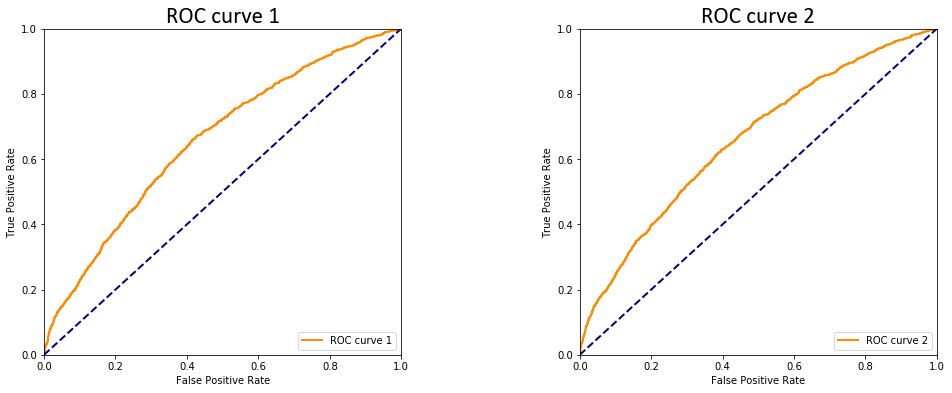

In [66]:
# 画 两个 auc 图。

font1 = {'family': 'Calibri','weight': 'normal','size': 18} # 轴标签字体
font2 = {'family': 'Calibri','weight': 'normal','size': 23} # 图标题字体

fig3 = plt.figure(figsize = (16,6))
lw = 2 # 线宽？
ax1 = fig3.add_subplot(121)
ax1.plot(fpr1,tpr1,color="darkorange",lw=2, label="ROC curve 1")
ax1.plot([0,1],[0,1],color="navy",lw=lw, linestyle="--")
ax1.set_xlim(0.0, 1.0)
ax1.set_ylim(0.0, 1.0)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve 1',fontdict=font2)
ax1.legend(loc="lower right")

ax2 = fig3.add_subplot(122)
ax2.plot(fpr2,tpr2,color="darkorange",lw=2, label="ROC curve 2")
ax2.plot([0,1],[0,1],color="navy",lw=lw, linestyle="--")
ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC curve 2',fontdict=font2)
ax2.legend(loc="lower right")

plt.subplots_adjust(wspace = 0.5, hspace =0.5)  # 调整每个子图之间的距离    
plt.show()

结论：   
1. 阈值为 0.8时，auc1 = 0.6477, auc2 = 0.6519，提示用2.3.2得到的特征训练LR模型略好于用2.3.1得到的特征。
2. 经试验发现，如果以上步骤不变，仅调节 colinearity 中的阈值，也就是相关系数大于多少的特征对要删去其一，会发现，  
阈值为 0.6时，auc1 = 0.6324, auc2 = 0.6447  
阈值为 0.7时，auc1 = 0.6398, auc2 = 0.6468  
阈值为 0.8时，auc1 = 0.6477, auc2 = 0.6519  
阈值为 0.9时，auc1 = 0.6556, auc2 = 0.6552  
阈值为 1.0时，auc1 = 0.6586, auc2 = 0.6583  
这似乎提示，不删除强相关的特征，即保留所有特征会更好？  
3. 改变 LR 的超参数C并不会引起 AUC值改变太多。（相关系数阈值0.8）   
C为  1 时，auc1 = 0.647744 , acu2 = 0.651925  
C为 10 时，auc1 = 0.647729 , acu2 = 0.651930  
C为100 时，auc1 = 0.647727 , acu2 = 0.651935   
所以并没有特别大的改观。  
4. 试过增大LR模型的max_iter，发现基本没有变化。（阈值0.8，C为1）   
max_iter为  100 时，auc1 = 0.647744 , acu2 = 0.651925
max_iter为 1000 时，auc1 = 0.647744 , acu2 = 0.651925


## 2.5 训练 LR 模型  

1. 沿用计算XGBOOST特征重要性时得到的数据集：将训练集data_tr进行train_test_split二八分（此函数里面有shuffle和stratify选项），得到字段部分和目标变量部分分类得X_tr_train, X_tr_test, y_tr_train, y_tr_test。然后，因为2.4中显示特征选择会降低AUC，所以此处不进行特征选择，而是使用所有特征进行训练。训练集X_tr_train，y_tr_train。验证集X_tr_test，y_tr_test。
2. LR模型只有一个超参数C。使用 pipeline，将 “标准化StandardScaler”和“LR模型”组成管道。通过GridSearchCV进行对LR的超参数C进行交叉验证，粗选出最佳C。
3. 在最佳C下，LR模型对完整数据集X_tr_train，y_tr_train进行fit，得到最佳模型，然后对验证集X_tr_test，y_tr_test进行预测，并计算auc和ks评分。
4. 围绕粗选出的最佳C设置一个小范围，使用 hyperopt 进行精细的选择。得到最佳C。
5. 将完整训练集进行五折交叉验证（在最佳C下），得到5个 auc和ks值供参考。
6. 在最佳C下，对完整训练集X_tr,y_tr训练LR模型，得到的模型对未知样本集 X_te进行预测，保存预测结果 LRPre. 

### 2.5.1 准备数据集。
&ensp;&ensp;沿用计算XGBOOST特征重要性时得到的数据集：将训练集data_tr进行train_test_split二八分（此函数里面有shuffle和stratify选项），得到字段部分和目标变量部分分类得X_tr_train, X_tr_test, y_tr_train, y_tr_test。然后，因为2.4中显示特征选择会降低AUC，所以此处不进行特征选择，而是使用所有特征进行训练。 训练集X_tr_train，y_tr_train可用于之后的交叉验证求最佳超参数。验证集X_tr_test，y_tr_test可用于得到最佳超参数并训练出最佳模型后，用此模型对验证集进行预测，计算auc。

In [67]:
# 沿用之前 算 XGBOOST 特征重要性时 对训练集 X_tr, y_tr 进行 二八分 得到的 
# 训练集X_tr_train， y_tr_train和 测试集X_tr_test，y_tr_test。(shuffle + stratify)

print("shape of X_tr_train is:",X_tr_train.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test is:",X_tr_test.shape)
print("shape of y_tr_test is:",y_tr_test.shape)

shape of X_tr_train is: (44304, 424)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 424)
shape of y_tr_test is: (11077,)


In [68]:
X_tr_train

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_max,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
950,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,20.376736,20.376736,10.188368,0.000000,2.000000,42.631748,5915633487
52463,0,1,0,0,0,1,0,0,0,0,...,0.292912,0.114795,0.027480,23.711041,13.974282,9.369504,6.058268,5.000000,60.501599,5931617487
26796,0,1,0,0,0,1,0,0,0,0,...,0.363387,0.072343,0.026336,24.047356,14.173112,9.999985,4.925065,3.000000,39.814708,5928247887
32880,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,21.069883,21.069883,0.000000,0.000000,4.000000,41.442164,5929198287
32092,0,0,1,0,0,0,1,0,0,0,...,0.000000,0.000000,0.000000,20.153592,20.153592,0.000000,0.000000,3.000000,43.813742,5929111887
20755,0,1,0,0,0,1,0,0,0,0,...,0.209804,0.081805,0.082555,20.787442,14.377279,9.839627,5.415019,6.000000,123.130841,5927211087
16790,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,20.664418,20.664418,20.664418,20.664418,1.000000,20.664418,5926779087
9438,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,20.868333,20.868333,10.434166,0.000000,2.000000,42.689812,5924791887
31099,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,39.362723,19.748127,0.000000,0.000000,5.000000,61.413435,5928939087


### 2.5.2 GridSearchCV 交叉验证粗取最佳超参数

In [69]:
# LR模型只有一个超参数C。使用 pipeline，将 “标准化StandardScaler”和“LR模型”组成管道。
# 通过GridSearchCV对训练集X_tr_train，y_tr_train进行5折交叉验证，从而实现对LR的超参数C进行
# 交叉验证，选出最佳C。

# ks_score = make_scorer(ks_statistic,greater_is_better=True,needs_proba=False)
LR_parameter = {"penalty": "l2","tol": 1e-4,"class_weight": 'balanced', 
                'solver': 'liblinear','max_iter':100,'random_state':3}
pipe1 = Pipeline([ ("standard", StandardScaler()) ,("LR", LogisticRegression(**LR_parameter)) ])

# 只对C这一个超参数进行网格搜索。给出C的粗范围。
param_grid = dict(LR__C=[0.001,0.01,0.1, 1, 10, 100, 1000]) 

# scoring指定了多个函数，则交叉验证会算多个score。而应该依据哪个函数的返回值来选择最佳超参数？在refit里指定。
timestart = time.time()
grid_search = GridSearchCV( pipe1, param_grid=param_grid, cv=5, scoring="roc_auc", refit="roc_auc")  
grid_search.fit(X_tr_train,y_tr_train)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

Time: 0.617 hours


In [70]:
# 返回最佳超参数值，可见最佳C是0.01
grid_search.best_params_  

{'LR__C': 0.01}

### 2.5.3 对验证集进行预测并求得AUC---法1

进行预测。法1  
  
说明：  
&ensp;&ensp;我是这样理解的，GridSearchCV 去 fit(X_tr_train,y_tr_train)时，首先按照cv=5的要求分成五折（按照GridSearchCV的规定，是分层抽样但不随机shuffle。好在我刚开始已经手动shuffle过了。则这样实现了“shuffle+分层”的抽样方法），然后，把第一种情况（4折训练集，1折验证集）包括它们对应的目标y值传给pipe，pipe里的StandardScaler先接触到 4折训练集+1折验证集，StandardScaler会对4折训练集进行 fit+transform标准化，然后把学到的均值方差应用到1折验证集上，对其也标准化（应该不会对目标变量y进行标准化，因为，查阅StandardScaler的文档，发现它的fit方法的参数里是有y的，但不会对y进行任何处理，我认为是StandardScaler为了兼容其它方法，比如这里的pipeline，还是保留了y参数，从而有一个传递的效果），然后，标准化后的4折训练集+1折验证集，以及不变的y 传递给LR模型，而且此时GridSearchCV 选定尝试超参数C=0.001，LR模型进行训练，得到在C=0.001下的模型，并对验证集进行预测，对比验证集真实结果，用scoring=”roc_auc”即auc标准，算得auc值。 后续过程参见GridSearchCV原理。总之，GridSearchCV会对每个超参数组合进行5次训练，得到5个score取平均，谁的平均score最高，则谁是最佳的超参数C值。  
&ensp;&ensp;grid_search.best_params_ 返回这个最佳C。  
&ensp;&ensp;另外，因为GridSearchCV设置 refit=true，所以得到最佳C后，会在整个数据集上再尝试，这时，整个数据集X_tr_train,y_tr_train给到了StandardScaler，它直接将X_tr_train标准化，保留y_tr_train不变，并记录了X_tr_train的均值方差标准。然后，把标准化的X_tr_train,y_tr_train给到了LR模型，在最佳C下对整个训练集训练出模型，这个模型存储在grid_search.best_estimator_。另外我认为，对于 GridSearchCV来说，“模型”这个概念指的是pipe，毕竟GridSearchCV的第一个参数我写的是pipe而非LR，所以，我认为这个最佳模型应该是pipe，即包含了StandardScaler和LR，其中，StandardScaler是对标准化的整个训练集进行fit得到的，所以我认为它里面是包含了整个训练集的均值方差。而LR是对整个标准化训练集在C为最佳C下训练得到的。  
&ensp;&ensp;然后，grid_search. predict_proba(X_tr_test)会用这个存储在grid_search.best_estimator_里的模型预测测试集X_tr_test，因为StandardScaler已经存储了整个训练集的均值方差，所以可以直接用在X_tr_test上。这样是对的。然后，把标准化后的X_tr_test传递给最佳LR模型，进行预测。  
&ensp;&ensp;grid_search. score(X_tr_test,y_tr_test) 同样是用grid_search.best_estimator_里的最佳模型对X_tr_test进行标准化，预测，评分，这里用的是scoring=”roc_auc”定义的auc分值。  

In [71]:
# 返回最佳模型。是在最佳超参数 C= 下，对整个训练集 X_tr_train，y_tr_train进行学习得到的模型。
grid_search.best_estimator_  

Pipeline(memory=None,
     steps=[('standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('LR', LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=3,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [72]:
# 返回使用最佳超参数值进行五折训练时，得到的 5个score的均值，且是 refit指定的 auc指标的均值。
# 可见，最佳C时，五折训练得到的五个模型对各自验证集预测的auc得分的均值为 0.6687 。
grid_search.best_score_  

0.6687085665187095

In [73]:
# 对测试集 X_tr_test 进行属于正类别1的概率预测
grid_search.predict_proba(X_tr_test)

array([[0.57849826, 0.42150174],
       [0.54401289, 0.45598711],
       [0.56817054, 0.43182946],
       ...,
       [0.75230456, 0.24769544],
       [0.57148205, 0.42851795],
       [0.79973481, 0.20026519]])

In [74]:
# 使用best_estimator_里的最佳模型对测试集样本进行预测并计算score。score指标使用 refit指定的auc指标。
# 可见，最佳模型对测试集预测的auc是0.67左右。
grid_search.score(X_tr_test,y_tr_test)

0.6736258454927472

In [75]:
# 算一下 ks 评分。可见， KS评分还是很低的。
ks_value = ks_statistic(np.array(y_tr_test),grid_search.predict_proba(X_tr_test)[:,1])
# 注意此处，千万不要把 左侧的变量的名字定义为 ks_statistic，否则算出值后，此变量会指向一个值，而非一个函数。
# 下一次再调用 ks_statistic时就会出错。犯过这个错了已经。
print("ks_value is: ",ks_value)

ks_value is:  0.2531851273014329


### 2.5.4 对验证集进行预测并求得AUC---法2

进行预测。法2  
  
说明：  
&ensp;&ensp;grid_search.best_params_ 得到了最佳C。然后，将之带入到pipe中，这时，pipe里的LR模型的C就固定了，然后，pipe.fit(X_tr_train,y_tr_train)，首先，StandardScaler接触到X_tr_train,y_tr_train，会对X_tr_train进行fit和transform，即进行标准化并记录X_tr_train的均值方差。然后，把标准化后的X_tr_train和未更改的y_tr_train给到LR，则LR会在最佳C下fit此数据，得到最佳模型。    
&ensp;&ensp;pipe.predict_proba(X_tr_test)是用次最佳模型对X_tr_test进行预测，首先还是StandardScaler接触到X_tr_test，但它已经存储了X_tr_train的均值方差，所以直接应用到X_tr_test上即可，然后把标准化的X_tr_test给到了LR模型进行预测。  
&ensp;&ensp;然后调用 roc函数计算auc。  
&ensp;&ensp;我个人认为法1和法2的predict_proba 和 auc 结果应该是相同的。事实却是是相同的。证明法1法2等效。


In [76]:
# 返回最佳超参数值，可见最佳C是0.01
grid_search.best_params_  

{'LR__C': 0.01}

In [77]:
# 这里使用了将 C值代入 pipe，得到最终 pipe的方式。用 pipe 对测试集样本进行预测，计算auc。

pipe1.set_params(LR__C=0.01)  # 最佳超参数值代入pipe里
pipe1.fit(X_tr_train,y_tr_train)  # 整个训练集 X_tr_train，y_tr_train进行学习得到的模型
pipe1.predict_proba(X_tr_test) # 可见这个结果和法 1 完全相同。

array([[0.57849826, 0.42150174],
       [0.54401289, 0.45598711],
       [0.56817054, 0.43182946],
       ...,
       [0.75230456, 0.24769544],
       [0.57148205, 0.42851795],
       [0.79973481, 0.20026519]])

In [78]:
# 可见这个结果和法 1 完全相同。
roc_auc_score(y_tr_test, pipe1.predict_proba(X_tr_test)[:,1])

0.6736258454927472

In [79]:
# 算一下 ks 评分。KS评分与法1相同，还是很低的。

ks_value2 = ks_statistic(np.array(y_tr_test),pipe1.predict_proba(X_tr_test)[:,1]) 
print("ks_statistic value is: ",ks_value2)

ks_statistic value is:  0.2531851273014329


### 2.5.5 查看并分析详细信息

In [80]:
pd.DataFrame(grid_search.cv_results_)

C:\Users\shuangjun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shuangjun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shuangjun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shuangjun\Anaconda3\lib\site-package

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_LR__C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,7.523072,0.097417,0.668404,0.688195,0.001,{'LR__C': 0.001},2,0.661475,0.689332,0.673732,...,0.670303,0.688127,0.675233,0.685825,0.661277,0.689425,0.217116,0.005246,0.005957,0.001299
1,13.152604,0.097906,0.668709,0.697705,0.01,{'LR__C': 0.01},1,0.662170,0.698298,0.674069,...,0.671247,0.697847,0.676060,0.695352,0.659997,0.698740,1.177897,0.015664,0.006448,0.001210
2,28.857286,0.091473,0.666029,0.700738,0.1,{'LR__C': 0.1},3,0.660869,0.701249,0.671096,...,0.667301,0.701206,0.672500,0.698432,0.658381,0.701238,2.841289,0.002870,0.005555,0.001160
3,49.669865,0.103478,0.664636,0.701218,1,{'LR__C': 1},4,0.659878,0.701719,0.669784,...,0.665416,0.701717,0.670792,0.698963,0.657310,0.701665,4.535571,0.010750,0.005316,0.001135
4,71.639859,0.134100,0.664315,0.701236,10,{'LR__C': 10},5,0.659523,0.701715,0.669459,...,0.665095,0.701738,0.670400,0.698998,0.657096,0.701690,13.188302,0.026935,0.005276,0.001126
5,127.147871,0.183122,0.664275,0.701233,100,{'LR__C': 100},6,0.659477,0.701709,0.669416,...,0.665062,0.701736,0.670345,0.698998,0.657074,0.701689,23.030121,0.024778,0.005268,0.001125
6,134.359709,0.171950,0.664270,0.701233,1000,{'LR__C': 1000},7,0.659471,0.701709,0.669413,...,0.665059,0.701735,0.670338,0.698998,0.657072,0.701689,23.683411,0.008605,0.005267,0.001125


分析：  
&ensp;&ensp;grid_search.cv_results_记录了整个GridSearchCV 交叉验证期间的详细信息，可以通过dataframe格式展示。param_LR__C一列记录了超参数C的需要尝试的值，共7个。此表每一行是一个C值下的数据。split0_test_roc_auc，split1_test_roc_auc，，，split4_test_roc_auc是在此C值下五折交叉验证求得的五个模型对各自测试集进行预测，然后计算的auc值。（同理，split0_train_roc_auc等是五个模型对各自训练集进行预测，然后计算的auc值。没错，也可以对训练集进行预测）。mean_test_roc_auc是此C值下五个模型对各自测试集进行预测计算的auc值的平均值，mean_train_roc_auc是此C值下五个模型对各自训练集进行预测计算的auc值的平均值。通过比较各个C的mean_test_roc_auc，发现最大的是C为0.01时的mean_test_roc_auc，此值也会被存储在grid_search.best_score_，此值对应的C就是最佳C。  
&ensp;&ensp;仔细观察C为0.001,0.01,0.1时的mean_test_roc_auc和mean_train_roc_auc。可见，随着C增加，正则程度下降，对训练集的拟合程度增加，mean_train_roc_auc值升高，这是很正常的。但是，mean_test_roc_auc却先升后降，说明C由0.001到0.01时是由欠拟合到正常的变化过程，而由0.01到0.1则是正常到过拟合的过程（过拟合导致对验证集的预测效果下降）。所以，0.01是较好的。

### 2.5.6 hyperopt 求取最佳超参数

&ensp;&ensp;GridSearchCV只是求出了超参数C的大致范围，即0.001到0.1之间。我们把C的范围限制在这里，通过hyperopt在这个参数范围内寻找最佳C值。首先，使用训练LR时使用的二八分数据：训练集X_tr_train，y_tr_train, 测试集X_tr_test，y_tr_test。按照hyperopt的用法，需要自定义一个函数，给出超参数范围，hyperopt在这个范围内选择值，然后代入这个函数，求得函数值，使函数值最小的那个就是最佳超参数。我们这样定义函数LRfunction：对训练集X_tr_train，y_tr_train进行五折划分，在某C下，分别学得5个模型，用模型对各自的测试集预测并求auc，求得5个auc值的均值的负数，作为函数返回值，可见，此值越小，说明 auc均值越大，说明这个C固定值越佳。

In [81]:
# 使用训练LR模型使用的二八分数据：训练集X_tr_train，y_tr_train, 测试集X_tr_test，y_tr_test

print("shape of X_tr_train is:",X_tr_train.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test is:",X_tr_test.shape)
print("shape of y_tr_test is:",y_tr_test.shape)

shape of X_tr_train is: (44304, 424)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 424)
shape of y_tr_test is: (11077,)


In [82]:
# 然后，对训练集X_tr_train，y_tr_train进行一次性五折划分。
# Xt 存储了 5个二维array，分别是5份训练集。  
# Xv 存储了 5个二维array，分别是对应的5份验证集。
# Yt 存储了 5个一维array，分别是对应的5份训练集的标签。
# Yv 存储了 5个一维array，分别是对应的5份验证集的标签。


skf = StratifiedKFold (n_splits=5,shuffle=True,random_state=2)  
# 保证了即shuffle又分层。（其实二八分时已经shuffle过了，此处可以不shuffle，也可以再shuffle一次）
Xt = []
Yt = []
Xv = []
Yv = []
for train_index, validation_index in skf.split(X_tr_train.values,y_tr_train.values):  
    Xt.append(X_tr_train.values[train_index])
    Yt.append(y_tr_train.values[train_index])
    Xv.append(X_tr_train.values[validation_index])
    Yv.append(y_tr_train.values[validation_index])

In [83]:
Xt

[array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         5.00000000e+00, 6.05015990e+01, 5.93161749e+09],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         4.00000000e+00, 4.14421640e+01, 5.92919829e+09],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
         3.00000000e+00, 4.38137420e+01, 5.92911189e+09],
        ...,
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         8.00000000e+00, 1.54479904e+02, 5.92686549e+09],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         2.00000000e+00, 4.01248630e+01, 5.92755669e+09],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         7.00000000e+00, 1.22143875e+02, 5.92695189e+09]]),
 array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         2.00000000e+00, 4.26317480e+01, 5.91563349e+09],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         3.00000000e+00, 3.98147080e+01, 5.92824789e+09],
        [0.00000000e+00, 

In [84]:
Yt

[array([0., 0., 0., ..., 0., 0., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 1.]),
 array([0., 0., 0., ..., 0., 0., 1.]),
 array([0., 0., 0., ..., 0., 0., 1.])]

In [85]:
# 此段代码用 hyperopt 加 交叉验证 选择 LR 模型的最优超参数。
#（5折交叉验证）将此训练集一次性随机分成5份，以其中4份作为训练集，1份作为验证集。给模型代入一组固定的超参数值，然后，
# 用此模型对这4份训练集进行学习，用学得的模型对那1份验证集进行预测，然后，对比验证集的预测值和真实值（用Score函数，计算AUC值），
# 得到score。因为是5折，所以可以学得5个模型，进行5次相应预测，得到5个score值（这5个模型用的都是同一组超参数值），
# 求这5个score的平均值的负值，即 -np.mean(score)。将这个过程构成函数 LRfunction，这个-np.mean(score)就是LRfunction的返回值，
# 是hyperopt的评价依据。然后，定义超参数空间space，设置搜索算法algo参数，然后，使用fmin方法在超参数空间中选择能使 -np.mean(score)
# 值最小的那组超参数值。这样，就得到了最佳超参数值。
# 此处，LR 模型 只用 hyperopt 加 交叉验证 选择 "C" 这一个超参数的最优值。
# 另外，还使用了 trials 捕捉了在每一次尝试中使用的 C值 和 对应得到 的-np.mean(score)值（即loss列）


LR_parameter_space ={'C':hp.uniform('C', 0.001, 0.1)}  
# 
# 对 LR 模型来说，只对 C 这一个超参数调参。我本来用的是 hp.loguniform("C", -6.9, -2.3)，
# 这个根据粗选结果来设定。exp(-6.9)=0.001, exp(-4.6)=0.01,  exp(-2.3)=0.1 
# [exp(-6.9),exp(-2.3)]间的log分布。但我发现这样不太好，因为这个分布对 0.001到0.01之间的数值
# 尝试的比较多，而对 0.01到 0.1 之间的尝试的很少。所以我改成了均匀分布。


def LRfunction(args):
    # args是LR_parameter_space
    LR_parameter = {"penalty": "l2", "class_weight": 'balanced', 'solver': 'liblinear',
                    'random_state':5,'max_iter':100,'tol':0.005} 
                    # 这个随机数是因为liblinear使用了随机过程。另外max_iter需要增加么？
    LR_parameter.update(args)
    clf = LogisticRegression(**LR_parameter)
   
    score = []
    for i in range(len(Xt)):
        # 标准化数据集
        scaler = StandardScaler()
        scaler.fit(Xt[i])
        Xti_std = scaler.transform(Xt[i])  # std表示标准化过
        Xvi_std = scaler.transform(Xv[i])
        # 训练模型
        clf.fit(Xti_std,Yt[i])
        # 若此时 print('LR_classes:',clf.classes_) ， 结果为：array([0, 1], dtype=int64)，即类别 0 先，类别 1 后。
        # 预测验证集
        proba_prediction = clf.predict_proba(Xvi_std)
        # 所得到的 proba_prediction 是一个 二维 array，第一列是预测每个样属于第 0 类的概率，
        # 第二列是每个样属于第1类的概率。(与clf.classes_ 顺序保持一致)
        
        score.append(roc_auc_score(Yv[i],proba_prediction[:,1]))  
        # 所以这里是 proba_prediction[:,1] 取第二列。
  
    return -np.mean(score)

timestart = time.time()
LRtrials = Trials()
LRbest = fmin(fn = LRfunction, space = LR_parameter_space, algo=tpe.suggest, max_evals=30,trials=LRtrials)  # max_evals表示尝试30个C值，从中找最好的。可以先设为2，尝试一下。
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))


Time: 0.875 hours


In [86]:
# 这里记录了 hyperopt 在循环计算时的详细情况。因为 fmin中max_evals=30，也就是要从给出的C的范围（space参数）里选出30个C值进行试验。
# LRtrials.trials 是一个 list，里面有三个字典，即尝试 30 个C值时的详细情况。
# 每个字典里，misc是一个复合字典，里面的 vals 记录了尝试的 C值。

LRtrials.trials

[{'book_time': datetime.datetime(2019, 5, 5, 14, 28, 31, 871000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'idxs': {'C': [0]},
   'tid': 0,
   'vals': {'C': [0.051312253891688836]},
   'workdir': None},
  'owner': None,
  'refresh_time': datetime.datetime(2019, 5, 5, 14, 30, 38, 921000),
  'result': {'loss': -0.6647268659759156, 'status': 'ok'},
  'spec': None,
  'state': 2,
  'tid': 0,
  'version': 0},
 {'book_time': datetime.datetime(2019, 5, 5, 14, 30, 38, 926000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'idxs': {'C': [1]},
   'tid': 1,
   'vals': {'C': [0.01583310860869715]},
   'workdir': None},
  'owner': None,
  'refresh_time': datetime.datetime(2019, 5, 5, 14, 32, 4, 227000),
  'result': {'loss': -0.6660431043411293, 'status': 'ok'},
  'spec': None,
  'state': 2,
  'tid': 1,
  'version': 0},
 {'book_time': datetime.datetime(2019, 5, 5, 14, 32, 4, 235000),
  'exp_key': None,
  'misc': {'cmd': ('do

In [87]:
# LRtrials.losses() 为一个 list，里面有30个值，分别是尝试每个C值时，LRfunction 的返回值，即 5折交叉验证求得的5个score的均值的负数。

LRtrials.losses()

[-0.6647268659759156,
 -0.6660431043411293,
 -0.6659048687503877,
 -0.6651531747929157,
 -0.6651488012910984,
 -0.6655512344049385,
 -0.6642534105303828,
 -0.665045976036176,
 -0.6654222129425611,
 -0.6666950808800338,
 -0.6651505011285825,
 -0.6644099103175451,
 -0.6656660688433936,
 -0.664140182869174,
 -0.664233929155664,
 -0.6648171686495639,
 -0.666901524574961,
 -0.6643586950404371,
 -0.6651072983638426,
 -0.6647102143884753,
 -0.666890447910247,
 -0.6668263740678626,
 -0.6667191857579353,
 -0.666941884502366,
 -0.6662714640934977,
 -0.6664307211684525,
 -0.6645608094885601,
 -0.6669598648020906,
 -0.6654348995531414,
 -0.6648630872833035]

In [88]:
# 将结果组成 dataframe 表 LRop。
# 第一列为 尝试的 C值，第二列是 将此C代入 LRfunction 后求出的 平均auc 值。此值越大，说明此 C 越佳。（已按auc_mean从大到小排序）
# 使得 平均auc值最大的那个 C，就是 hyperopt 选出的最佳 C。即为首行 C 。

LRop = pd.concat([pd.DataFrame([sum(list(LRtrials.trials[j]["misc"]["vals"].values()), []) for j in range(len(LRtrials))],
                                 columns = list(LRtrials.trials[0]["misc"]["vals"].keys())),
           pd.DataFrame({"auc_mean":[np.abs(i) for i in LRtrials.losses()]})], axis = 1).sort_values(by=["auc_mean"],ascending=False)

In [89]:
LRop

,C,auc_mean
27,0.003316,0.666960
23,0.002957,0.666942
16,0.002569,0.666902
20,0.002538,0.666890
21,0.002205,0.666826
22,0.007139,0.666719
9,0.007290,0.666695
25,0.010579,0.666431
24,0.012625,0.666271
1,0.015833,0.666043


In [90]:
# 现在我们已经确定出了最佳的C值：0.005。然后在最佳C下对整个训练集X_tr_train, y_tr_train进行学习，学得的模型对X_tr_test, y_tr_test 进行预测。
# 可见，对验证集进行预测算auc，值为 0.67，并不高。ks 评分为0.25，也不高。

args = {"C":0.005}
LR_parameter = {"penalty": "l2", "class_weight": 'balanced', 'solver': 'liblinear',
                'random_state':5,'max_iter':100,'tol':0.005} 
LR_parameter.update(args)

# 之前 scaler2 已经 对 X_tr_train 和 X_tr_test 进行过了标准化如下，可以拿来直接用。
# scaler2 = StandardScaler()
# scaler2.fit(X_tr_train)
# X_tr_train_standard = scaler2.transform(X_tr_train)
# X_tr_test_standard = scaler2.transform(X_tr_test)

modelLR3 = LogisticRegression(**LR_parameter)
modelLR3.fit(X_tr_train_standard, y_tr_train)
proba_prediction3 = modelLR3.predict_proba(X_tr_test_standard)

# 计算AUC
roc_auc_score(y_tr_test, proba_prediction3[:,1])

0.6742869445263973

In [91]:
 # 算一下KS评分。
ks_statistic(np.array(y_tr_test), proba_prediction3[:,1]) 

0.25432697291306183

### 2.5.7 交叉验证  
&ensp;&ensp;以上过程是建立在一次性二八分，用八份去通过GridSearchCV+hyperopt得到最佳C，然后在此C下对这八份进行学习得到最佳模型，然后用最佳模型对那三份进行预测并计算AUC和KS。  
&ensp;&ensp;一次性二八分会否太单一？我认为可以在此C下使用交叉验证，多算几个验证分数。也就是把整个训练集X_tr, y_tr进行五折划分，在此C下学得5个模型，这5个模型对各自的验证集进行预测，得到5个auc和ks评分。可以看看这5个评分，算一下均分。

In [92]:
# 使用 cross_val_score 进行交叉验证
# 交叉验证显示，在最佳C下，训练的LR模型所得的auc评分也还在 0.65 左右，比较低。

pipe2 = make_pipeline(StandardScaler(), LogisticRegression(**LR_parameter))  # LR_parameter 是固定参数+最佳超参数 C
scores = cross_val_score(pipe2, X_tr, y_tr,cv = 5, scoring="roc_auc")  # 或试试cv=10
print("5Fold scores :", scores)
print("5Fold mean score :", np.mean(scores))

5Fold scores : [0.66117415 0.67825853 0.66142954 0.6396072  0.63259252]
5Fold mean score : 0.6546123878170597


### 2.5.8 训练最终LR模型并预测未知样本集

In [93]:
# 训练最终LR模型并预测未知样本集

scaler3=StandardScaler()
scaler3.fit(X_tr)
X_tr_std = scaler3.transform(X_tr)  # std代表标准化
X_te_std = scaler3.transform(X_te)
modelLR4 = LogisticRegression(**LR_parameter) # LR_parameter 是固定参数+最佳超参数 C
modelLR4.fit(X_tr_std, y_tr)
proba_prediction4 = modelLR4.predict_proba(X_te_std)

In [94]:
# 将预测结果整合成表

LRpre = pd.DataFrame(proba_prediction4[:,1],index=X_te.index,columns=["positive_proba"]).reset_index()
LRpre.columns = ["userid","probability"]  # 按官网提交示例修改列名

In [95]:
LRpre

,userid,probability
0,55597,0.727719
1,55598,0.100577
2,55599,0.520364
3,55600,0.410836
4,55601,0.516201
5,55602,0.686498
6,55603,0.554904
7,55604,0.627899
8,55605,0.387741
9,55606,0.510594


In [96]:
# 保存预测结果

LRpre.to_csv(r'F:\RiskPre2\result\LRpre.csv',index=False)

In [97]:
# 保存模型

joblib.dump(modelLR4, r'F:\RiskPre2\result\modelLR4.pkl')

['F:\\RiskPre2\\result\\modelLR4.pkl']

In [98]:
# 保存字段变量部分 X 和目标变量部分 Y 分开的： X_tr, y_tr, X_te, y_te

f1 = open(r'F:\RiskPre2\result\data_fill_XY.pkl', "wb")
pickle.dump(X_tr, f1, protocol=-1)
pickle.dump(y_tr, f1, protocol=-1)
pickle.dump(X_te, f1, protocol=-1)
pickle.dump(y_te, f1, protocol=-1)
f1.close()

In [99]:
# 保存训练集X_tr, y_tr进行二八划分得到的： X_tr_train, X_tr_test, y_tr_train, y_tr_test

f2 = open(r'F:\RiskPre2\result\split2_8.pkl', "wb")
pickle.dump(X_tr_train, f2, protocol=-1)
pickle.dump(y_tr_train, f2, protocol=-1)
pickle.dump(X_tr_test, f2, protocol=-1)
pickle.dump(y_tr_test, f2, protocol=-1)
f2.close()

with open(r'F:\RiskPre2\result\data_fill_XY.pkl', 'rb') as f:   # fill指填充过了缺失值。
    X_tr1 = pickle.load(f)
    y_tr1 = pickle.load(f)
    X_te1 = pickle.load(f)
    y_te1 = pickle.load(f)

# 3. 提交结果

In [100]:
# 提交 LRpre 结果：计算的 ks 值是： 0.21***6 ，很低，比之前提交的 3 次还低。